# Trying Data

Just some basic data viz in order to understand this mock data I need to work with. Sadly the data doesn't come with any units labeled so I'll need to guess them from the values in the data

In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as c
from scipy.integrate import quad

%matplotlib inline


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## `selection.h5`

In [2]:
f = "selection.h5"
with h5py.File(f, 'r') as hf:
    print(list(hf.keys()))
    print(array(hf['luminosity_distance']))
    
    print(array(hf['m1_detector']))
    print(array(hf['pdf']).shape)
    
    print(array(hf['q']))
    
    print(max(array(hf['luminosity_distance'])))
    print(max(array(hf['m1_detector'])))

['luminosity_distance', 'm1_detector', 'pdf', 'q']
[33.64908692 34.44066983 24.79243348 ... 32.05528094 33.47931232
  9.53308579]
[ 577.16707945 1303.33206373  188.1047686  ...  527.67417214  440.98571824
  199.32208634]
(3643000,)
[0.8553269  0.99688853 0.70056278 ... 0.60665041 0.62385364 0.51655413]
108.2141762734374
2958.8475577340673


Maybe the m1 and dL got switched somehow? Should plot them just to check...

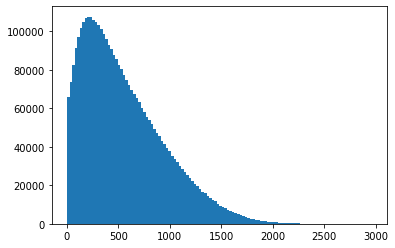

In [3]:
hf = h5py.File(f, 'r')
hist(array(hf['m1_detector']), bins = 120)
show()

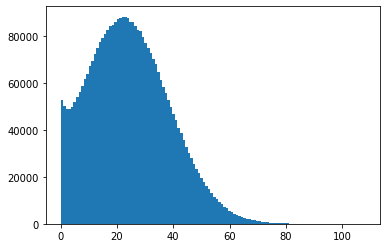

In [4]:
hf = h5py.File(f, 'r')
hist(array(hf['luminosity_distance']), bins = 120)
show()

Ok, so maybe not....But then what are these units? I'm pretty sure this is the right file since the keys in the other two don't seem to be what I'm looking for

Apparently I'm supposed to be using `observations.h5` actually so.....

## `observations.h5`

In [5]:
f = "observations.h5"
with h5py.File(f, 'r') as hf:
    print(list(hf.keys()))
    for item in list(hf.keys()):
        print(item, ": ", list(hf[item]))

['likelihood', 'observed', 'truth']
likelihood :  ['dl', 'logwt', 'm1_detector', 'q']
observed :  ['eta_obs', 'log_dl_obs', 'log_mc_obs', 'sigma_eta', 'sigma_log_dl', 'sigma_log_mc', 'snr_obs', 'snr_true']
truth :  ['m1_source', 'q', 'z']


(3643, 1000)
[[ 6.59349306  8.86409326  9.76509411 ... 10.16422168 10.96977086
   8.45382476]
 [ 4.13617897  4.04329904  4.32212997 ...  3.06382433  2.96812125
   4.10903079]
 [12.65077588 12.36294337 11.5392717  ... 12.2217392  12.66017059
  13.33708279]
 ...
 [ 5.50713454  6.35553588  5.9506653  ...  7.07910004  4.93976471
   5.78499867]
 [ 7.46507193  8.93226623  9.95238839 ...  8.41684042  6.15292742
   9.77308365]
 [ 6.64975173  5.67388348  7.15203338 ...  6.34050207  6.05096004
   7.48942135]]


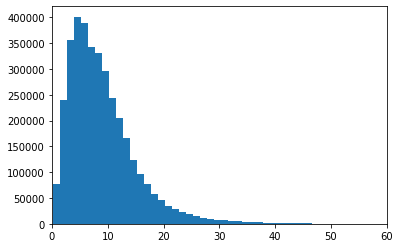

In [6]:
with h5py.File(f, 'r') as hf:
    print(array(hf['likelihood']['dl']).shape)
    print(array(hf['likelihood']['dl']))
    
    #looks like the data is 2D so it'll need to be flattened
    hist(array(hf['likelihood']['dl']).flatten(), bins=100)
    xlim(0, 60)

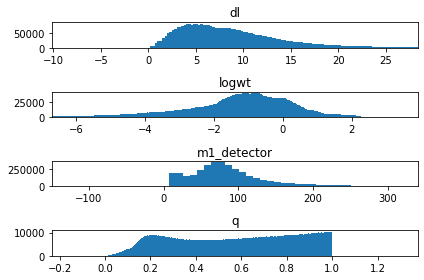

In [7]:
with h5py.File(f, 'r') as hf:    
    params = list(hf['likelihood'])
    
    fig, axs = subplots(len(params))
    
    for ind, param in enumerate(params):
        data = array(hf['likelihood'][param]).flatten()
        axs[ind].hist(data, bins=500)
        axs[ind].set_title(param)
        
        mu = mean(data)
        sigma =std(data)
        axs[ind].set_xlim(mu-3*sigma, mu+3*sigma)
        
    fig.tight_layout()

Okay, lets try generalizing the plotting a little further. Let's try getting ***every*** array of data plotted in the file...

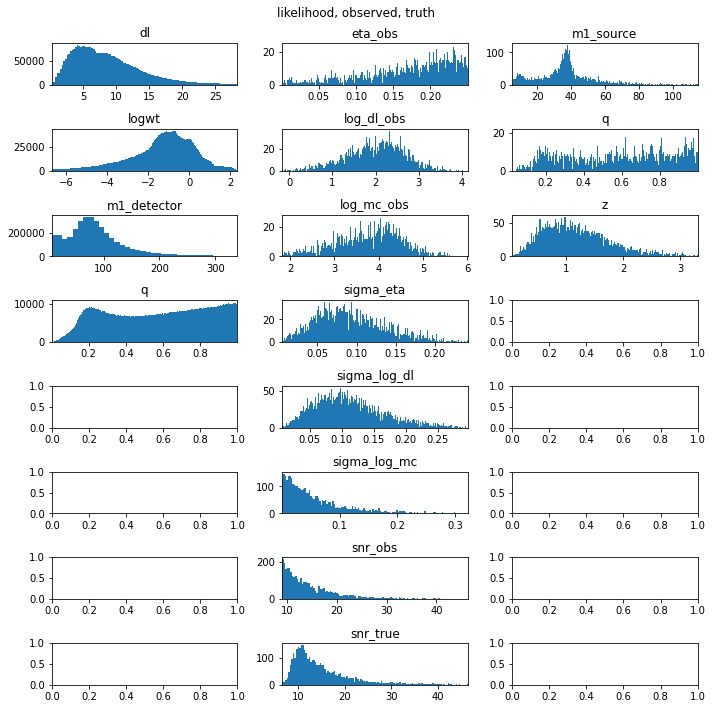

In [10]:
with h5py.File(f, 'r') as hf:
    keys = list(hf.keys())
    max_len = max([len(list(hf[key])) for key in keys])
    
    fig, axs = subplots(max_len, len(keys), figsize=(10, 10)) #yes I know it's only 3 keys, this keeps it general
    
    for ind_y, key in enumerate(keys):
        params = list(hf[key])
        for ind_x, param in enumerate(params):
            data = array(hf[key][param]).flatten()
            axs[ind_x][ind_y].hist(data, bins=500)
            axs[ind_x][ind_y].set_title(param)
            
            mu = mean(data)
            sigma =std(data)
            up = min(max(data), mu+3*sigma) #upper bound of plot
            low = max(min(data), mu-3*sigma)
            
            axs[ind_x][ind_y].set_xlim(low, up)
    
#     fig.suptitle(sum([str(k) for k in keys]))
    fig.suptitle("likelihood, observed, truth") #This breaks the earlier reason, but the line above didn't work
    fig.tight_layout()
    savefig('all_data.jpg')